In [1]:
import pandas as pd
from IPython.display import Image #type: ignore
from Utils import (
    convert_volume,
    plot_ts,
    decompose,
    test_adfuller,
    data_diff,
    test_diff_adfuller,
    mape_error,
    wmape_error,
    smape_error,
    acf_pacf,
    plot_error
)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    SeasonalWindowAverage,
    WindowAverage,
    RandomWalkWithDrift,
    HistoricAverage,
    AutoARIMA,
    AutoETS,
    AutoCES,
    AutoTheta,
    SimpleExponentialSmoothing,
    SimpleExponentialSmoothingOptimized,
    SeasonalExponentialSmoothing,
    SeasonalExponentialSmoothingOptimized,
    Holt,
    HoltWinters,
    ADIDA,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    IMAPA,
    TSB,
    MSTL,
    DynamicOptimizedTheta,
    GARCH,
    ARCH
)
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
import warnings
warnings.filterwarnings('ignore')

In [2]:
display(Image(url="Data/Tech_challenge_2.png", width=800, height=500))

- Carregar base

In [3]:
df = pd.read_csv('Data/Dados Históricos - Ibovespa.csv')
df.head()

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0  25.08.2023  115.837   117.025  117.252  115.397   9,21M  -1,02%
1  24.08.2023  117.026   118.135  118.136  116.848   9,20M  -0,94%
2  23.08.2023  118.135   116.160  118.135  116.159  11,54M   1,70%
3  22.08.2023  116.156   114.433  116.286  114.433   9,83M   1,51%
4  21.08.2023  114.429   115.404  115.425  114.067   9,79M  -0,85%

- Tratar valores

In [4]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [5]:
df[df['Vol.'].isnull()]

Data  Último  Abertura  Máxima  Mínima Vol.    Var%
1873  10.02.2016  40.377    40.592  40.592   39.96  NaN  -0,53%

In [6]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867 entries, 0 to 4866
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4867 non-null   object 
 1   Último    4867 non-null   float64
 2   Abertura  4867 non-null   float64
 3   Máxima    4867 non-null   float64
 4   Mínima    4867 non-null   float64
 5   Vol.      4867 non-null   object 
 6   Var%      4867 non-null   object 
dtypes: float64(4), object(3)
memory usage: 266.3+ KB


In [7]:
df.tail()

Data  Último  Abertura  Máxima  Mínima     Vol.    Var%
4862  08.01.2004  23.717    23.334  23.718  23.122  436,74M   1,70%
4863  07.01.2004  23.320    23.576  23.899  23.320  464,08M  -1,09%
4864  06.01.2004  23.576    23.532  23.976  23.180  472,38M   0,19%
4865  05.01.2004  23.532    22.445  23.532  22.445  496,71M   4,84%
4866  02.01.2004  22.445    22.233  22.450  22.208  136,42M   0,94%

- Converter colunas com valores tipo object

In [8]:
df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Var%'] = df['Var%'].apply(lambda x: x.replace('%', '').replace(',', '.') if isinstance(x, str) else x).astype(float)
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df.sort_values(by='Data', inplace=True)
df['ds'] = df['Data']
df['y'] = df['Último']
df.reset_index(drop=True, inplace=True)
df.head()

Data  Último  Abertura  Máxima  Mínima       Vol.  Var%         ds  \
0 2004-01-02  22.445    22.233  22.450  22.208  136420000  0.94 2004-01-02   
1 2004-01-05  23.532    22.445  23.532  22.445  496710000  4.84 2004-01-05   
2 2004-01-06  23.576    23.532  23.976  23.180  472380000  0.19 2004-01-06   
3 2004-01-07  23.320    23.576  23.899  23.320  464080000 -1.09 2004-01-07   
4 2004-01-08  23.717    23.334  23.718  23.122  436740000  1.70 2004-01-08   

        y  
0  22.445  
1  23.532  
2  23.576  
3  23.320  
4  23.717

In [9]:
print("Data mais antiga:", df['Data'].min())
print("Data mais recente:", df['Data'].max())

Data mais antiga: 2004-01-02 00:00:00
Data mais recente: 2023-08-25 00:00:00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867 entries, 0 to 4866
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4867 non-null   datetime64[ns]
 1   Último    4867 non-null   float64       
 2   Abertura  4867 non-null   float64       
 3   Máxima    4867 non-null   float64       
 4   Mínima    4867 non-null   float64       
 5   Vol.      4867 non-null   int64         
 6   Var%      4867 non-null   float64       
 7   ds        4867 non-null   datetime64[ns]
 8   y         4867 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int64(1)
memory usage: 342.3 KB


- Ajustar campo **Data** e **index**

In [11]:
df.set_index(df.Data, inplace=True)
df.drop('Data', inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4867 entries, 2004-01-02 to 2023-08-25
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Último    4867 non-null   float64       
 1   Abertura  4867 non-null   float64       
 2   Máxima    4867 non-null   float64       
 3   Mínima    4867 non-null   float64       
 4   Vol.      4867 non-null   int64         
 5   Var%      4867 non-null   float64       
 6   ds        4867 non-null   datetime64[ns]
 7   y         4867 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 342.2 KB


- análise

In [12]:
sns.set_style('darkgrid')

In [13]:
df.head()

Último  Abertura  Máxima  Mínima       Vol.  Var%         ds  \
Data                                                                       
2004-01-02  22.445    22.233  22.450  22.208  136420000  0.94 2004-01-02   
2004-01-05  23.532    22.445  23.532  22.445  496710000  4.84 2004-01-05   
2004-01-06  23.576    23.532  23.976  23.180  472380000  0.19 2004-01-06   
2004-01-07  23.320    23.576  23.899  23.320  464080000 -1.09 2004-01-07   
2004-01-08  23.717    23.334  23.718  23.122  436740000  1.70 2004-01-08   

                 y  
Data                
2004-01-02  22.445  
2004-01-05  23.532  
2004-01-06  23.576  
2004-01-07  23.320  
2004-01-08  23.717

#### Salvar csv com dados ajustados para o Streamlit

In [14]:
df.to_csv('df.csv')

- Vizualizando dados

In [15]:
fig = plot_ts(df)
fig.show()

- Decomposição do Fechamento

In [16]:
fig = decompose(df, 'Decomposição da Série Temporal - Último Fechamento')
fig.show()

- Outras decomposições

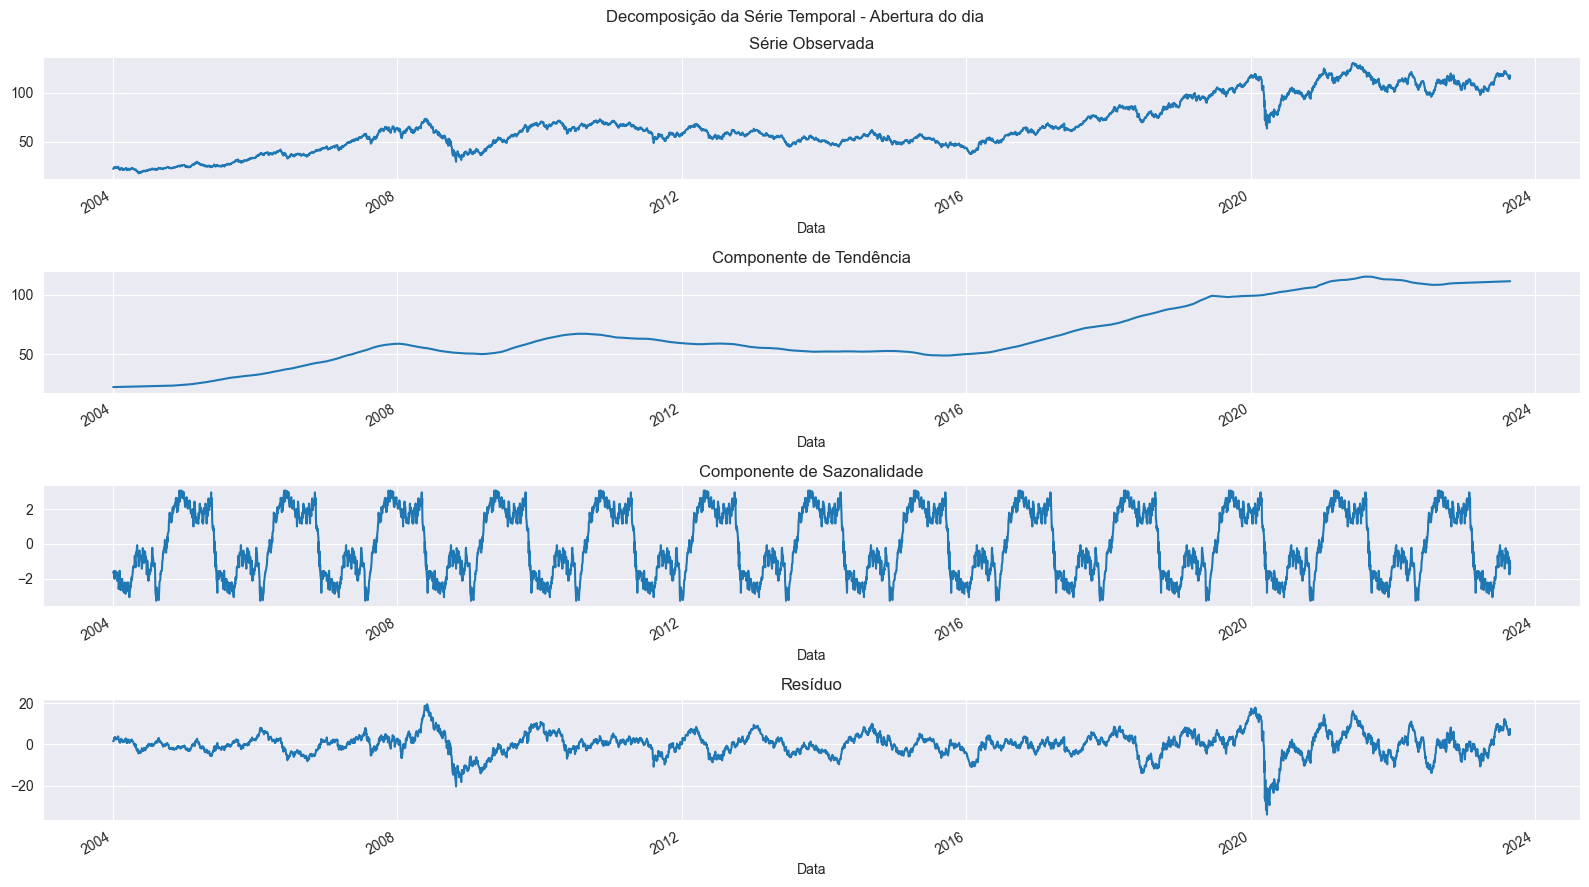

In [17]:
resultados = seasonal_decompose(df['Abertura'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Abertura do dia', fontsize=12)
plt.tight_layout()
plt.show()

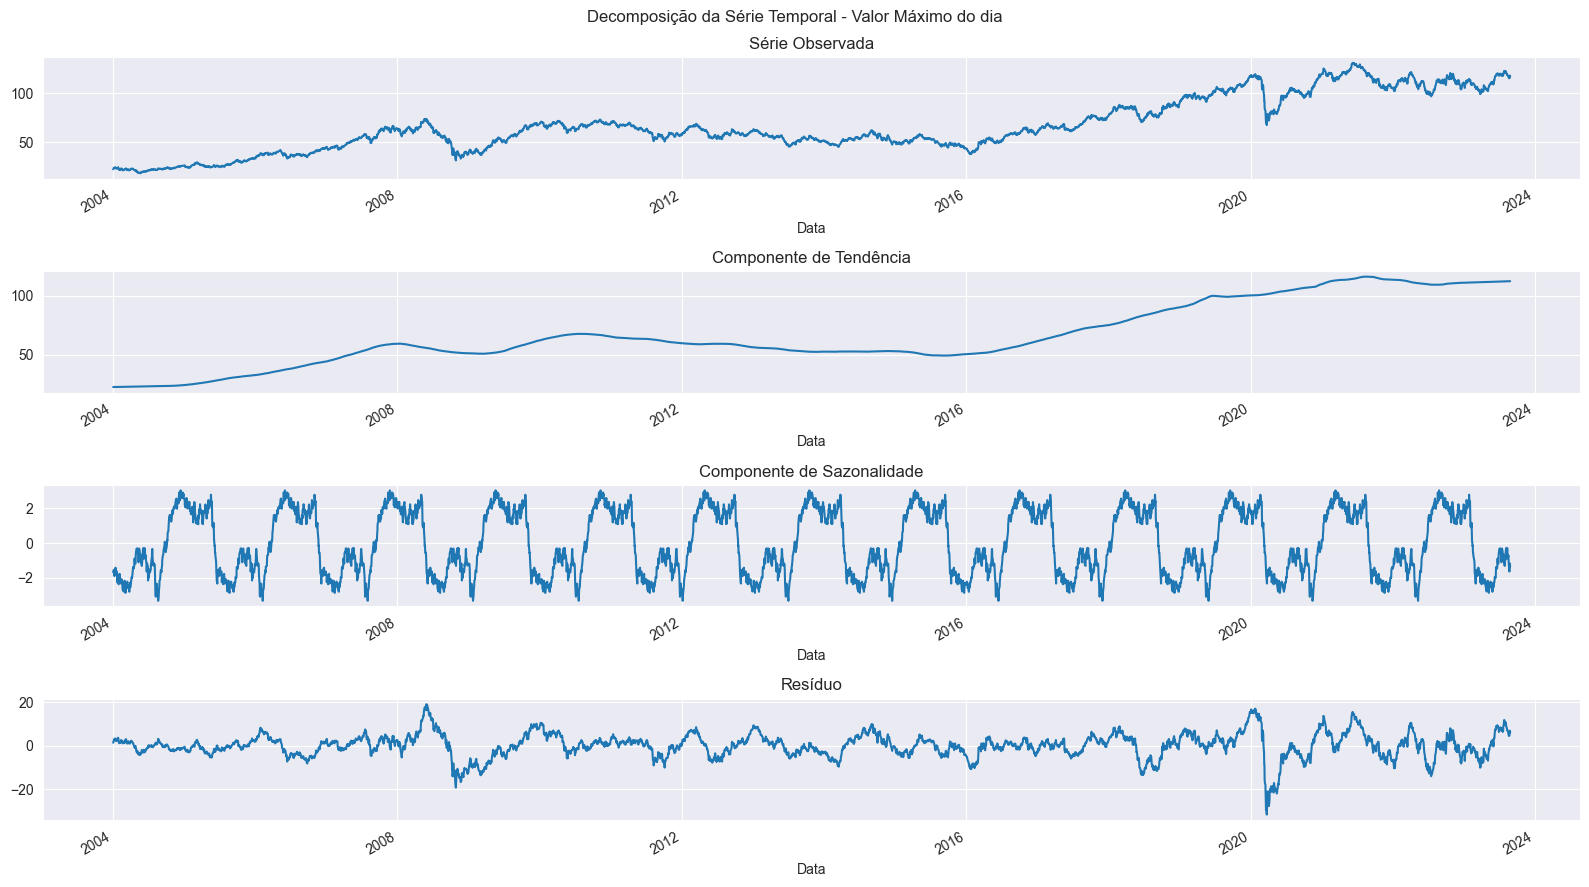

In [18]:
resultados = seasonal_decompose(df['Máxima'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Valor Máximo do dia', fontsize=12)
plt.tight_layout()
plt.show()

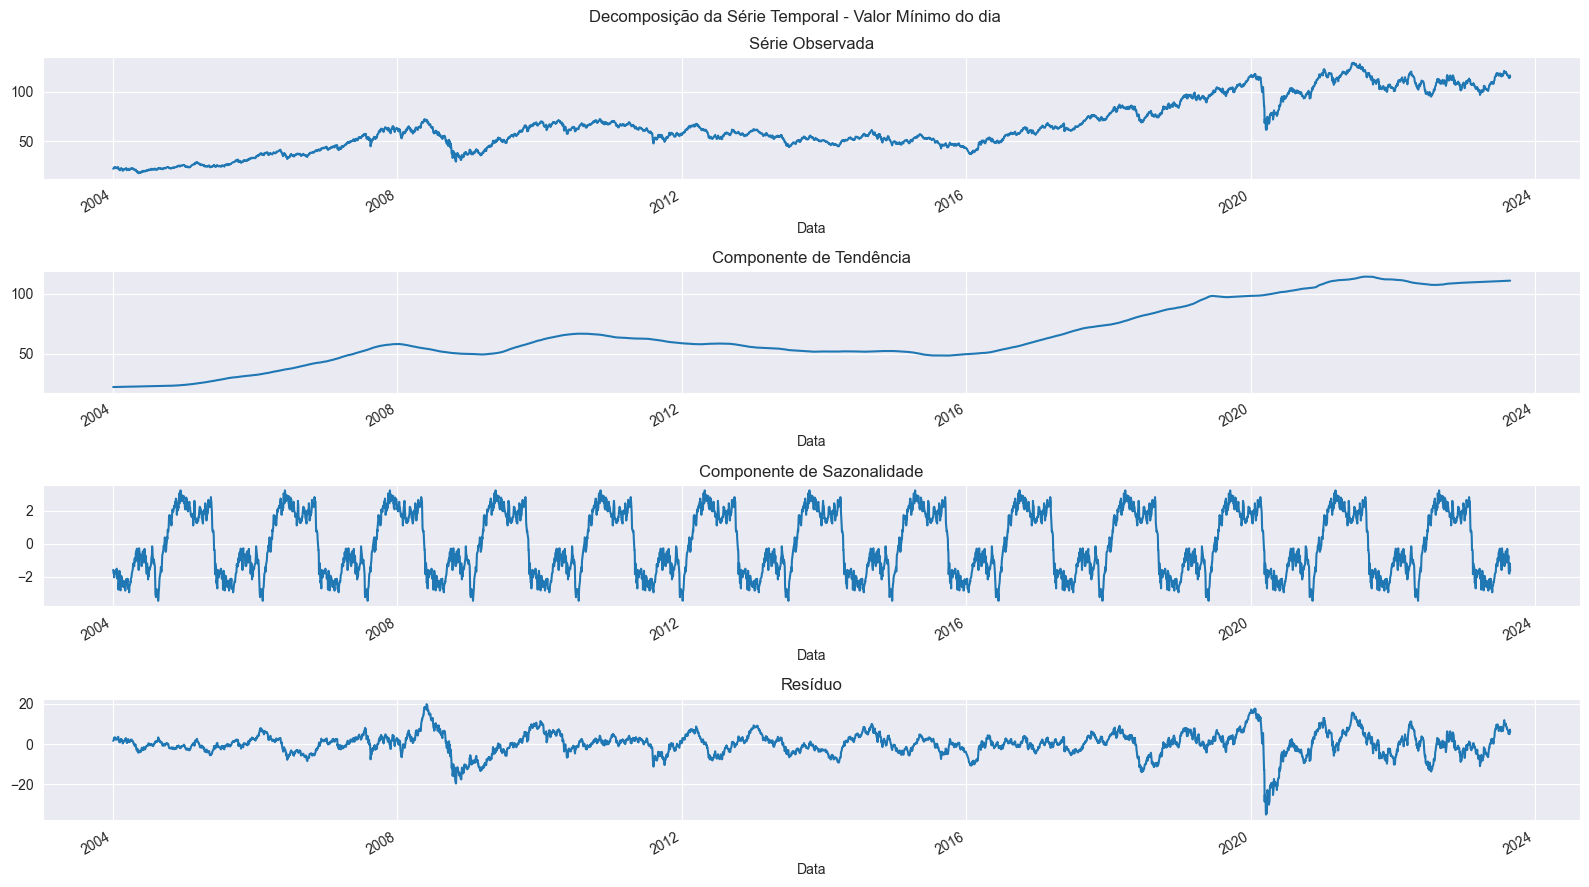

In [19]:
resultados = seasonal_decompose(df['Mínima'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Valor Mínimo do dia', fontsize=12)
plt.tight_layout()
plt.show()

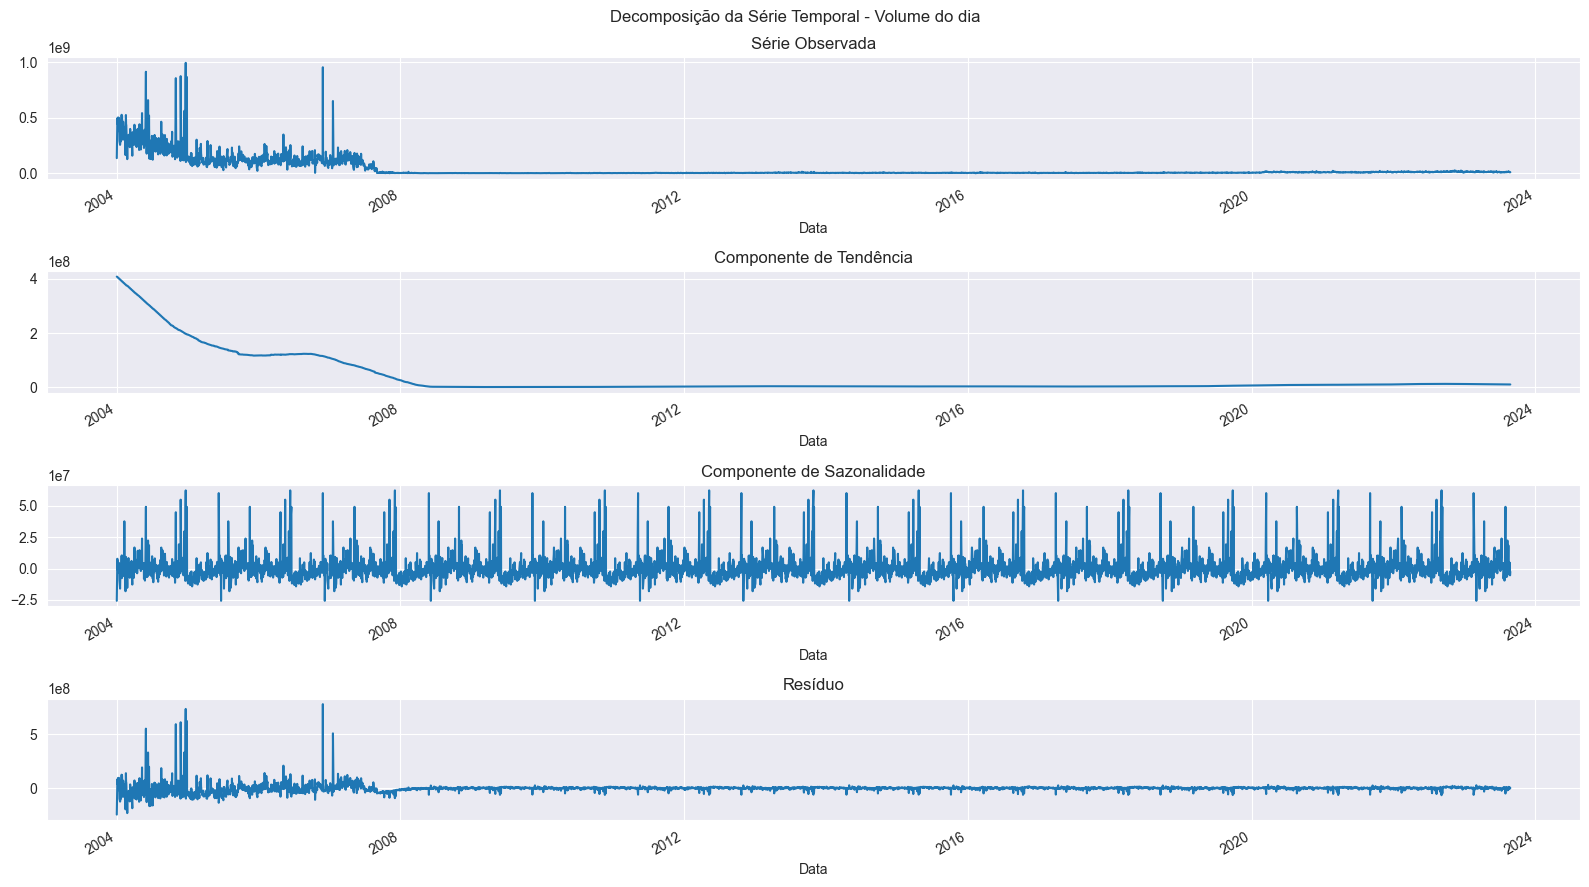

In [20]:
resultados = seasonal_decompose(df['Vol.'].dropna(), model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Volume do dia', fontsize=12)
plt.tight_layout()
plt.show()

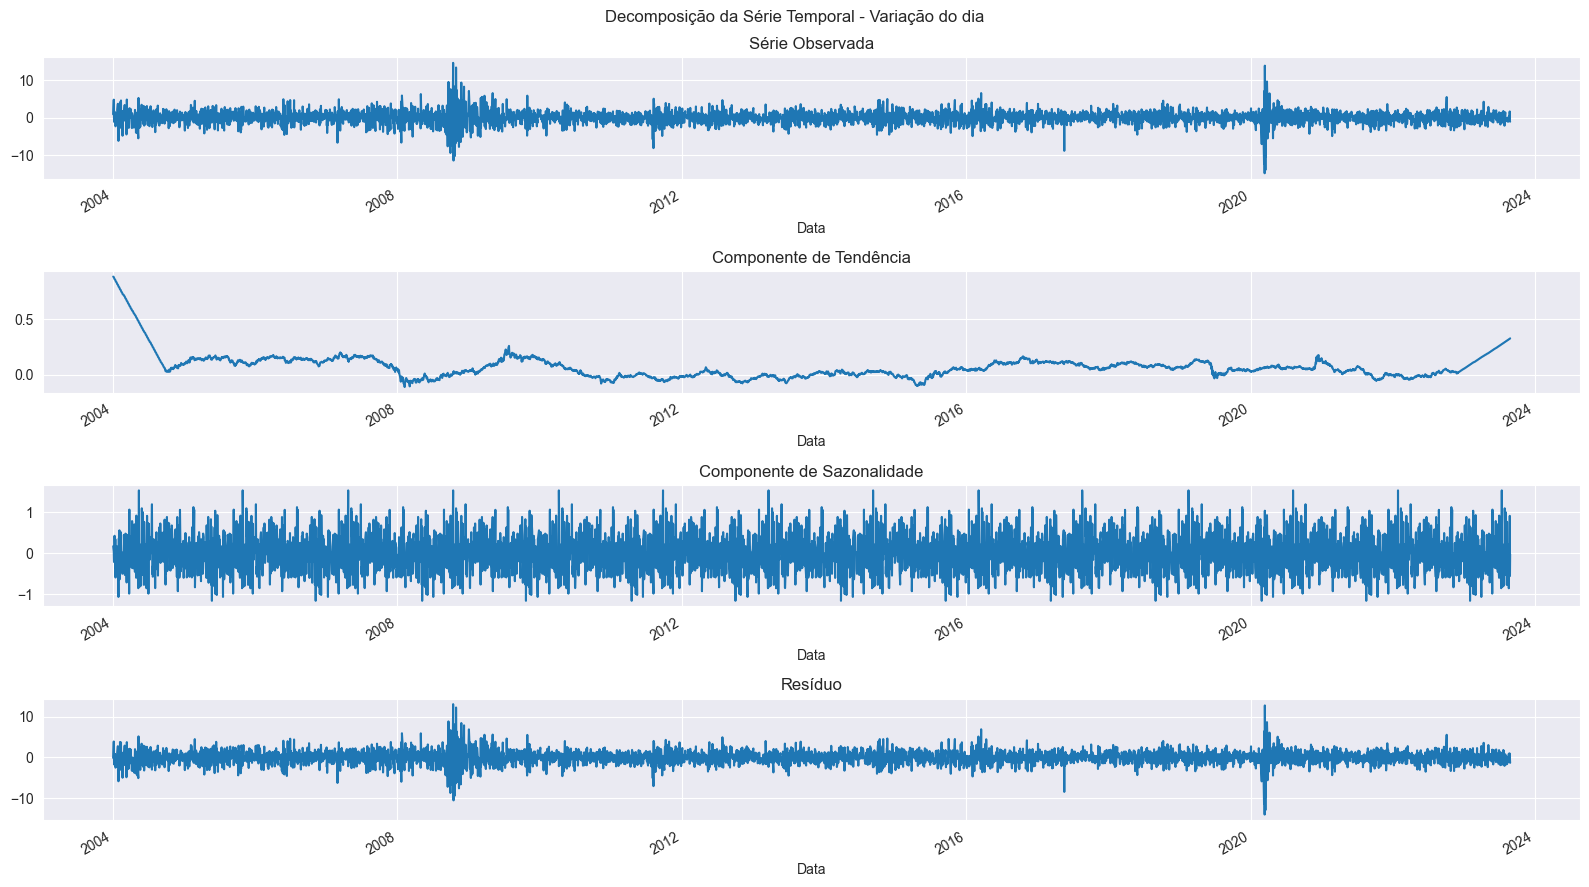

In [21]:
resultados = seasonal_decompose(df['Var%'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Variação do dia', fontsize=12)
plt.tight_layout()
plt.show()

#### Teste Augmented Dickey Fuller

> Hipótese
---
- H0 - Hipótese Nula (não é estacionária) não é estacionaria
- H1 - Hipótese Alternativa (rejeição da hipótese nula) é estacionaria

In [22]:
test_adfuller(df['Último'])

Teste ADf
Teste estatistico: -1.3285706938675355
P-Value: 0.616001960219223
Valores criticos:
	1%: -3.4316976335399527
	5%: -2.862135504385031
	10%: -2.5670869883787404


> Resultado
---
- p-value 62% e teste estatístico maior que os valores criticos: Não é estacionaria

In [23]:
test_adfuller(df['Abertura'])

Teste ADf
Teste estatistico: -1.300879299032239
P-Value: 0.628769937347135
Valores criticos:
	1%: -3.4316976335399527
	5%: -2.862135504385031
	10%: -2.5670869883787404


> Resultado
---
- p-value 63% e teste estatístico maior que os valores criticos: Não é estacionaria

In [24]:
test_adfuller(df['Máxima'])

Teste ADf
Teste estatistico: -1.2431211520538923
P-Value: 0.6547766254447387
Valores criticos:
	1%: -3.4316970783220078
	5%: -2.862135259095907
	10%: -2.5670868578012227


> Resultado
---
- p-value 65% e teste estatístico maior que os valores criticos: Não é estacionaria

In [25]:
test_adfuller(df['Mínima'])

Teste ADf
Teste estatistico: -1.318976628127238
P-Value: 0.6204463871331799
Valores criticos:
	1%: -3.4316970783220078
	5%: -2.862135259095907
	10%: -2.5670868578012227


> Resultado
---
- p-value 62% e teste estatístico maior que os valores criticos: Não é estacionaria

Converter séries Último fechamento em estacionarias

- remover tendencia e sazonalidade, fazer a aproximação(transformada logaritmo e subtrair da média móvel)
- média móvel aplicada a linha da tendencia
- uma janela móvel de tamanho 12 meses é aplicada sobre os dados
- aplicar log
- subtrair a média móvel
- derivadas de um número de polinômio de primeiro grau deixando mais estacionaria.

In [26]:
df_log = np.log(df[['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'y']])
df_log_meam = df_log.rolling(12).mean() # type: ignore
df_log = (df_log - df_log_meam).dropna()
df_diff = df_log.diff(1).dropna() # primeira derivada
df_ultimo_diff = df_diff['y']
df_ultimo_mean = df_ultimo_diff.rolling(12).mean()
df_ultimo_std = df_ultimo_diff.rolling(12).std()

In [27]:
data_diff(df_ultimo_diff, df_ultimo_mean, df_ultimo_std)

In [28]:
test_diff_adfuller(df_ultimo_diff)

Teste ADf
Teste estatistico: -18.913395569160432
P-Value: 0.0
Valores criticos:
	1%: -3.4317102480761292
	5%: -2.862141077334742
	10%: -2.5670899550918262


> Resultado
---
p-value 0.0% e teste estatístico menor que os valores criticos: É estacionaria

##### autocorrelação (ACF) e função de autocorrelação parcial (PACF)
---
- 5% ACF -> (intervalo de confiança).
- 1.96/sqrt(N-d) -> **N** número de pontos e **d** é o número de vezes que os dados foram diferenciamos (intervalo de confiança para estimativas de autocorrelação significativa).

$$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_{\text{true},i} - y_{\text{pred},i}}{y_{\text{true},i}} \right| \times 100$$
---
$$WMAPE = \frac{\sum_{i=1}^{n} \left| y_{\text{true},i} - y_{\text{pred},i} \right|}{\sum_{i=1}^{n} \left| y_{\text{true},i} \right|} \times 100$$
---
$$SMAPE = \frac{100}{n} \sum_{i=1}^{n} \frac{\left| y_{\text{pred},i} - y_{\text{true},i} \right|}{(|y_{\text{pred},i}| + |y_{\text{true},i}|)/2}$$

In [29]:
fig = acf_pacf(df_ultimo_diff)
fig.show()

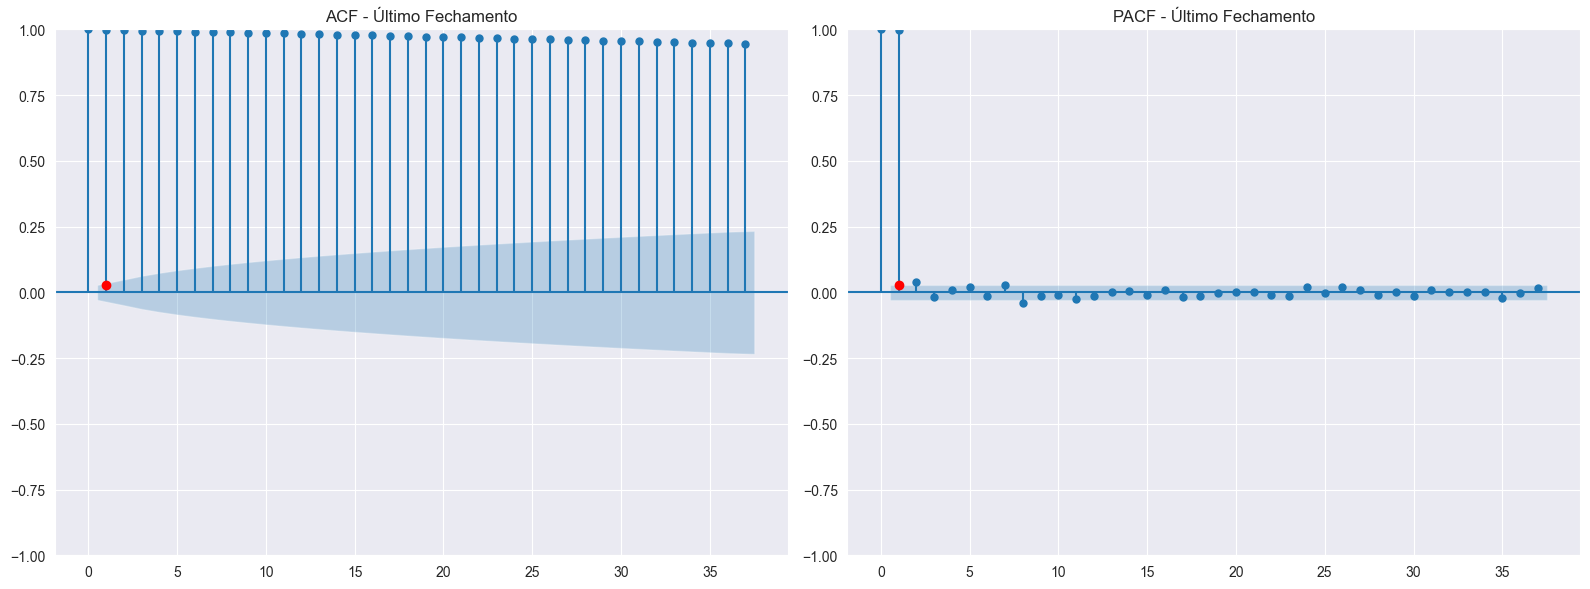

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Último'], ax=ax[0])
ax[0].set_title('ACF - Último Fechamento')
ax[0].plot(1, 1.96/np.sqrt(len(df['Último']) - 1), 'ro')
plot_pacf(df['Último'], ax=ax[1])
ax[1].set_title('PACF - Último Fechamento')
ax[1].plot(1, 1.96/np.sqrt(len(df['Último']) - 1), 'ro')
plt.savefig('ACF e PACF - originais') # exportando para streamlit
plt.tight_layout()
plt.show()

#####  ARIMA (P, D, Q)
---
- Ordem de diferenciação **D** = 1 (Foi necessária 1 diferenciação para tornar a série estacionaria)
- **Q acf** = 0.915
- **P pacf** = 0.915

In [31]:
df_model = df.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], axis=1)
df_diff_model = df_diff.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1)
df_diff_model['ds'] = df_model['ds']

In [32]:
df_model.head(10)

ds       y
Data                         
2004-01-02 2004-01-02  22.445
2004-01-05 2004-01-05  23.532
2004-01-06 2004-01-06  23.576
2004-01-07 2004-01-07  23.320
2004-01-08 2004-01-08  23.717
2004-01-09 2004-01-09  23.917
2004-01-12 2004-01-12  24.237
2004-01-13 2004-01-13  23.940
2004-01-14 2004-01-14  23.399
2004-01-15 2004-01-15  22.962

- Tratamento de datas faltantes: preencher sábados e domingos com média móvel da semana

In [33]:
date_range = pd.date_range(start=df_model.index.min(), end=df_model.index.max(), freq='D')
df_model = df_model.reindex(date_range)
rolling_mean = df_model['y'].rolling(window=6, min_periods=1).mean()
is_null_sequence = df_model['y'].isnull()
df_model['y'] = np.where(is_null_sequence, rolling_mean, df_model['y'])
df_model['ds'] = df_model.index
df_model.index.name = 'Data'
df_model.to_csv('df_model.csv')
df_model.head(10)

ds        y
Data                          
2004-01-02 2004-01-02  22.4450
2004-01-03 2004-01-03  22.4450
2004-01-04 2004-01-04  22.4450
2004-01-05 2004-01-05  23.5320
2004-01-06 2004-01-06  23.5760
2004-01-07 2004-01-07  23.3200
2004-01-08 2004-01-08  23.7170
2004-01-09 2004-01-09  23.9170
2004-01-10 2004-01-10  23.6124
2004-01-11 2004-01-11  23.6325

In [34]:
df_model.isnull().sum().sum()

0

In [35]:
df_diff_model.tail()

y         ds
Data                           
2023-08-21 -0.004160 2023-08-21
2023-08-22  0.017350 2023-08-22
2023-08-23  0.017768 2023-08-23
2023-08-24 -0.007975 2023-08-24
2023-08-25 -0.008382 2023-08-25

In [36]:
date_range = pd.date_range(start=df_diff_model.index.min(), end=df_diff_model.index.max(), freq='D')
df_diff_model = df_diff_model.reindex(date_range)
rolling_mean = df_diff_model['y'].rolling(window=21, min_periods=1).mean()
is_null_sequence = df_diff_model['y'].isnull()
df_diff_model['y'] = np.where(is_null_sequence, rolling_mean, df_diff_model['y'])
df_diff_model['ds'] = df_diff_model.index
df_diff_model.index.name = 'Data'
df_diff_model.to_csv('df_diff_model.csv')
df_diff_model.head(10)

y         ds
Data                           
2004-01-20  0.008034 2004-01-20
2004-01-21 -0.015231 2004-01-21
2004-01-22 -0.012220 2004-01-22
2004-01-23  0.021082 2004-01-23
2004-01-24  0.000416 2004-01-24
2004-01-25  0.000416 2004-01-25
2004-01-26  0.034571 2004-01-26
2004-01-27 -0.006175 2004-01-27
2004-01-28 -0.014224 2004-01-28
2004-01-29 -0.057839 2004-01-29

In [37]:
df_diff_model.isnull().sum()

y     0
ds    0
dtype: int64

- Separação dos dados de treino, teste e validação

In [38]:
train = df_model.loc[df_model.ds < '2023-07-01']
test = df_model.loc[(df_model.ds >= '2023-07-01') & (df_model.ds < '2023-08-16')]
valid = df_model.loc[df_model.ds >= '2023-08-16']

train_diff = df_diff_model.loc[df_diff_model.ds < '2023-07-01']
test_diff = df_diff_model.loc[(df_diff_model.ds >= '2023-07-01') & (df_diff_model.ds < '2023-08-16')]
valid_diff = df_diff_model.loc[df_diff_model.ds >= '2023-08-16']

h = test['ds'].nunique()

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7120 entries, 2004-01-02 to 2023-06-30
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      7120 non-null   datetime64[ns]
 1   y       7120 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 166.9 KB


In [40]:
test_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46 entries, 2023-07-01 to 2023-08-15
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       46 non-null     float64       
 1   ds      46 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [41]:
valid_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2023-08-16 to 2023-08-25
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       10 non-null     float64       
 1   ds      10 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 240.0 bytes


In [42]:
train.loc[:, 'unique_id'] = 'Fechamento'
test.loc[:, 'unique_id'] = 'Fechamento'
valid.loc[:, 'unique_id']  = 'Fechamento'
train_diff.loc[:, 'unique_id'] = 'Fechamento'
test_diff.loc[:, 'unique_id'] = 'Fechamento'
valid_diff.loc[:, 'unique_id']  = 'Fechamento'
print(f'Treino normal: {train.shape}')
print(f'Teste normal: {test.shape}')
print(f'Validação normal: {valid.shape}')
print(f'Treino tratado: {train_diff.shape}')
print(f'Teste tratado: {test_diff.shape}')
print(f'Validação tratado: {valid_diff.shape}')
print(h)

Treino normal: (7120, 3)
Teste normal: (46, 3)
Validação normal: (10, 3)
Treino tratado: (7102, 3)
Teste tratado: (46, 3)
Validação tratado: (10, 3)
46


In [43]:
valid.head()

ds         y   unique_id
Data                                       
2023-08-16 2023-08-16  115.5920  Fechamento
2023-08-17 2023-08-17  114.9820  Fechamento
2023-08-18 2023-08-18  115.4090  Fechamento
2023-08-19 2023-08-19  115.7928  Fechamento
2023-08-20 2023-08-20  115.5385  Fechamento

#### Salvar para streamlit

In [44]:
train.to_csv('train.csv')
test.to_csv('test.csv')
valid.to_csv('valid.csv')
test_diff.to_csv('test_diff.csv')
train_diff.to_csv('train_diff.csv')
valid_diff.to_csv('valid_diff.csv')

In [45]:
model = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['SeasonalNaive'].values)
# smape = smape_error(forecast['y'].values, forecast['SeasonalNaive'].values)
# mape = mape_error(forecast['y'].values, forecast['SeasonalNaive'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['SeasonalNaive'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['SeasonalNaive'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['SeasonalNaive'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.31%


WMAPE (Weighted Mean Absolute Percentage Error): 2.17%


In [46]:
model = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2)], freq='D', n_jobs=-1) #season_length 5 = seg a sex window_size 2 = 2 semanas/mes
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['SeasWA'].values)
# smape = smape_error(forecast['y'].values, forecast['SeasWA'].values)
# mape = mape_error(forecast['y'].values, forecast['SeasWA'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['SeasWA'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['SeasWA'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['SeasWA'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.05%


WMAPE (Weighted Mean Absolute Percentage Error): 2.42%


In [47]:
model = StatsForecast(models=[SeasonalExponentialSmoothingOptimized(season_length=7)], freq='D', n_jobs=-1)
model.fit(train.dropna())
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['SeasESOpt'].values)
# smape = smape_error(forecast['y'].values, forecast['SeasESOpt'].values)
# mape = mape_error(forecast['y'].values, forecast['SeasESOpt'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['SeasESOpt'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['SeasESOpt'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['SeasESOpt'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.28%


WMAPE (Weighted Mean Absolute Percentage Error): 2.04%


In [48]:
model = StatsForecast(models=[HoltWinters(season_length=7, error_type='M')], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['HoltWinters'].values)
# smape = smape_error(forecast['y'].values, forecast['HoltWinters'].values)
# mape = mape_error(forecast['y'].values, forecast['HoltWinters'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['HoltWinters'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['HoltWinters'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['HoltWinters'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.20%


WMAPE (Weighted Mean Absolute Percentage Error): 1.81%


In [49]:
model = StatsForecast(models=[MSTL(season_length=[5, 7], trend_forecaster=AutoARIMA(season_length=1, start_P=1, start_Q=1))], freq='D', n_jobs=-1) #type: ignore
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['MSTL'].values)
# smape = smape_error(forecast['y'].values, forecast['MSTL'].values)
# mape = mape_error(forecast['y'].values, forecast['MSTL'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['MSTL'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['MSTL'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['MSTL'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.79%


WMAPE (Weighted Mean Absolute Percentage Error): 1.16%


In [50]:
model = StatsForecast(models=[MSTL(season_length=[5, 7], trend_forecaster=AutoETS(model='AZN'))], freq='D', n_jobs=-1) #type: ignore
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['MSTL'].values)
# smape = smape_error(forecast['y'].values, forecast['MSTL'].values)
# mape = mape_error(forecast['y'].values, forecast['MSTL'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['MSTL'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['MSTL'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['MSTL'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.83%


WMAPE (Weighted Mean Absolute Percentage Error): 1.11%


In [51]:
model = StatsForecast(models=[DynamicOptimizedTheta(season_length=7)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values)
# smape = smape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values)
# mape = mape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['DynamicOptimizedTheta'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['DynamicOptimizedTheta'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['DynamicOptimizedTheta'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.13%


WMAPE (Weighted Mean Absolute Percentage Error): 2.00%


In [52]:
model = StatsForecast(models=[AutoARIMA(season_length=7, start_P=1, start_Q=1)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['AutoARIMA'].values)
# smape = smape_error(forecast['y'].values, forecast['AutoARIMA'].values)
# mape = mape_error(forecast['y'].values, forecast['AutoARIMA'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['AutoARIMA'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['AutoARIMA'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['AutoARIMA'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.22%


WMAPE (Weighted Mean Absolute Percentage Error): 1.76%


In [53]:
model = StatsForecast(models=[AutoCES(model='Z', season_length=7)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['CES'].values)
# smape = smape_error(forecast['y'].values, forecast['CES'].values)
# mape = mape_error(forecast['y'].values, forecast['CES'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['CES'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['CES'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['CES'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.09%


WMAPE (Weighted Mean Absolute Percentage Error): 2.16%


In [54]:
model = StatsForecast(models=[AutoTheta(decomposition_type='multiplicative', model='DOTM', season_length=7)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['AutoTheta'].values)
# smape = smape_error(forecast['y'].values, forecast['AutoTheta'].values)
# mape = mape_error(forecast['y'].values, forecast['AutoTheta'].values)

model.plot(
    train,
    forecast,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

forecast_valid = model.predict(h=h + 10, level=[95])
forecast_valid = forecast_valid.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_valid.dropna(inplace=True)

wmape = wmape_error(forecast_valid['y'].values, forecast_valid['AutoTheta'].values)
# smape = smape_error(validacaodatas['y'].values, forecast_valid['AutoTheta'].values)
# mape = mape_error(forecast_valid['y'].values, forecast_valid['AutoTheta'].values)

model.plot(
    valid,
    forecast_valid,
    level=[95],
    # engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.13%


WMAPE (Weighted Mean Absolute Percentage Error): 2.00%


- Treinamento de modelos

In [55]:
model = StatsForecast(
    models=[
        Naive(),
        SeasonalNaive(season_length=7),
        SeasonalWindowAverage(season_length=7, window_size=2),
        WindowAverage(window_size=2),
        RandomWalkWithDrift(),
        HistoricAverage(),
        SimpleExponentialSmoothing(alpha=0.001),
        SimpleExponentialSmoothingOptimized(),
        SeasonalExponentialSmoothing(alpha=0.001, season_length=7),
        SeasonalExponentialSmoothingOptimized(season_length=7),
        Holt(season_length=7, error_type='M'),
        HoltWinters(season_length=7, error_type='M'),
        ADIDA(),
        CrostonClassic(),
        CrostonOptimized(),
        CrostonSBA(),
        IMAPA(),
        TSB(alpha_d=0.005, alpha_p=0.005),
        MSTL(season_length=[5, 7], trend_forecaster=AutoETS(model='AZN')), # type: ignore
        DynamicOptimizedTheta(season_length=7),
        GARCH(p=10, q=1),
        AutoARIMA(season_length=7, start_P=1, start_Q=1),
        AutoETS(model='ZZZ', season_length=7),
        AutoCES(model='Z', season_length=7),
        AutoTheta(decomposition_type='multiplicative', model='DOTM', season_length=7),
        ARCH(p=10)
    ],
    freq='D',
    n_jobs=-1
)

model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

- SARIMAX

In [56]:
sarima_model = SARIMAX(train['y'], order=(1, 1, 1), seasonal_order=(0, 1, 0, 7))
sarima = sarima_model.fit(disp=False)

sarima_forecast = sarima.get_forecast(steps=h) # type: ignore
sarima_forecast_result = sarima_forecast.predicted_mean
sarima_df = pd.DataFrame({'predicted_mean': sarima_forecast_result.values}, index=test.index)

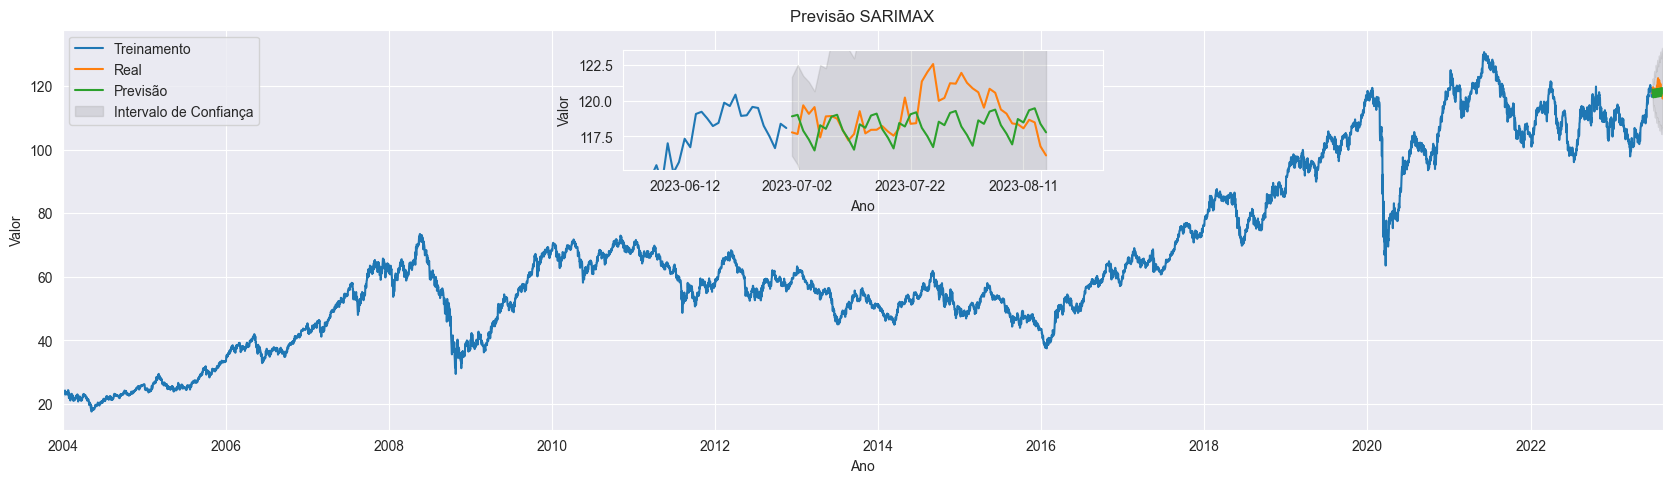

In [57]:
fig = plt.figure(figsize=(16, 4))
eixo = fig.add_axes([0, 0, 1, 1])
eixo.plot(train['y'], label='Treinamento')
eixo.plot(test.index, test['y'], label='Real')
eixo.plot(sarima_df.index, sarima_df['predicted_mean'], label='Previsão')
eixo.fill_between(
    sarima_forecast.conf_int().index,
    sarima_forecast.conf_int()['lower y'],
    sarima_forecast.conf_int()['upper y'],
    color='gray',
    alpha=0.2,
    label='Intervalo de Confiança'
)
eixo.legend()
eixo.set_title('Previsão SARIMAX')
eixo.set_xlim(pd.Timestamp('2004-01-01'), test.index[-1]) # type: ignore
eixo.set_xlabel('Ano')
eixo.set_ylabel('Valor')
eixo2 = fig.add_axes([0.35, 0.65, 0.3, 0.3])
eixo2.plot(train['y'], label='Treinamento')
eixo2.plot(test.index, test['y'], label='Real')
eixo2.plot(sarima_df.index, sarima_df['predicted_mean'], label='Previsão')
eixo2.fill_between(
    sarima_forecast.conf_int().index,
    sarima_forecast.conf_int()['lower y'],
    sarima_forecast.conf_int()['upper y'],
    color='gray',
    alpha=0.2,
    label='Intervalo de Confiança'
)
eixo2.set_ylim(
    min(min(test['y']), min(sarima_df['predicted_mean'])) - 1, # type: ignore
    max(max(test['y']), max(sarima_df['predicted_mean'])) + 1 # type: ignore
)
eixo2.set_xlim(pd.Timestamp('2023-06-01'), pd.Timestamp('2023-08-25')) # type: ignore
eixo2.set_xlabel('Ano')
eixo2.set_ylabel('Valor')
eixo2.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
plt.show()

- LSTM

In [58]:
train_data = train['y'].values.reshape(-1, 1) # type: ignore
test_data = test['y'].values.reshape(-1, 1) # type: ignore

scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

# Função para criar sequências para a LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length-1]  # O último valor da sequência é usado como o alvo
        sequences.append((sequence, target))
    return sequences

seq_length = 7
train_sequences = create_sequences(train_data_normalized, seq_length)

X_train = np.array([seq for seq, _ in train_sequences])
y_train = np.array([target for _, target in train_sequences])

# Criação do modelo LSTM
# model = Sequential([
#     LSTM(units=50, activation='relu', input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 3.63%
# SMAPE (Symmetric Mean Absolute Percentage Error): 3.60%
# MAPE (Mean Absolute Percentage Error): 3.70%

# model = Sequential([
#     LSTM(units=50, activation='sigmoid', input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 4.82%
# SMAPE (Symmetric Mean Absolute Percentage Error): 4.92%
# MAPE (Mean Absolute Percentage Error): 4.80%

# model = Sequential([
#     LSTM(units=50, activation='tanh', input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 3.11%
# SMAPE (Symmetric Mean Absolute Percentage Error): 3.10%
# MAPE (Mean Absolute Percentage Error): 3.16%

model_lstm = Sequential([
    LSTM(units=50, activation='linear', input_shape=(seq_length, 1)),
    Dense(1)
])

# from keras.layers import LeakyReLU
# model = Sequential([
#     LSTM(units=50, activation=LeakyReLU(alpha=0.01), input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 5.05%
# SMAPE (Symmetric Mean Absolute Percentage Error): 4.94%
# MAPE (Mean Absolute Percentage Error): 5.16%

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=16)

# Preparação dos dados de teste para entrada na LSTM
last_sequence = train_data_normalized[-seq_length:]
forecast_lstm = []

for _ in range(h):
    predicted_value = model_lstm.predict(last_sequence.reshape(1, seq_length, 1))
    forecast_lstm.append(predicted_value)
    last_sequence = np.concatenate((last_sequence[1:], predicted_value), axis=None)

forecast_lstm = np.array(forecast_lstm).reshape(-1, 1)
forecast_lstm = scaler.inverse_transform(forecast_lstm)
forecast_lstm_values = forecast_lstm.flatten()

Epoch 1/50
445/445 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 2/50
445/445 [==============================] - 1s 2ms/step - loss: 1.4249e-04
Epoch 3/50
445/445 [==============================] - 1s 2ms/step - loss: 1.3153e-04
Epoch 4/50
445/445 [==============================] - 1s 2ms/step - loss: 1.2760e-04
Epoch 5/50
445/445 [==============================] - 1s 2ms/step - loss: 1.2491e-04
Epoch 6/50
445/445 [==============================] - 1s 2ms/step - loss: 1.2388e-04
Epoch 7/50
445/445 [==============================] - 1s 2ms/step - loss: 1.1358e-04
Epoch 8/50
445/445 [==============================] - 1s 2ms/step - loss: 1.0942e-04
Epoch 9/50
445/445 [==============================] - 1s 2ms/step - loss: 9.7775e-05
Epoch 10/50
445/445 [==============================] - 1s 2ms/step - loss: 9.4679e-05
Epoch 11/50
445/445 [==============================] - 1s 2ms/step - loss: 9.1030e-05
Epoch 12/50
445/445 [==============================] - 1s 2ms/step 

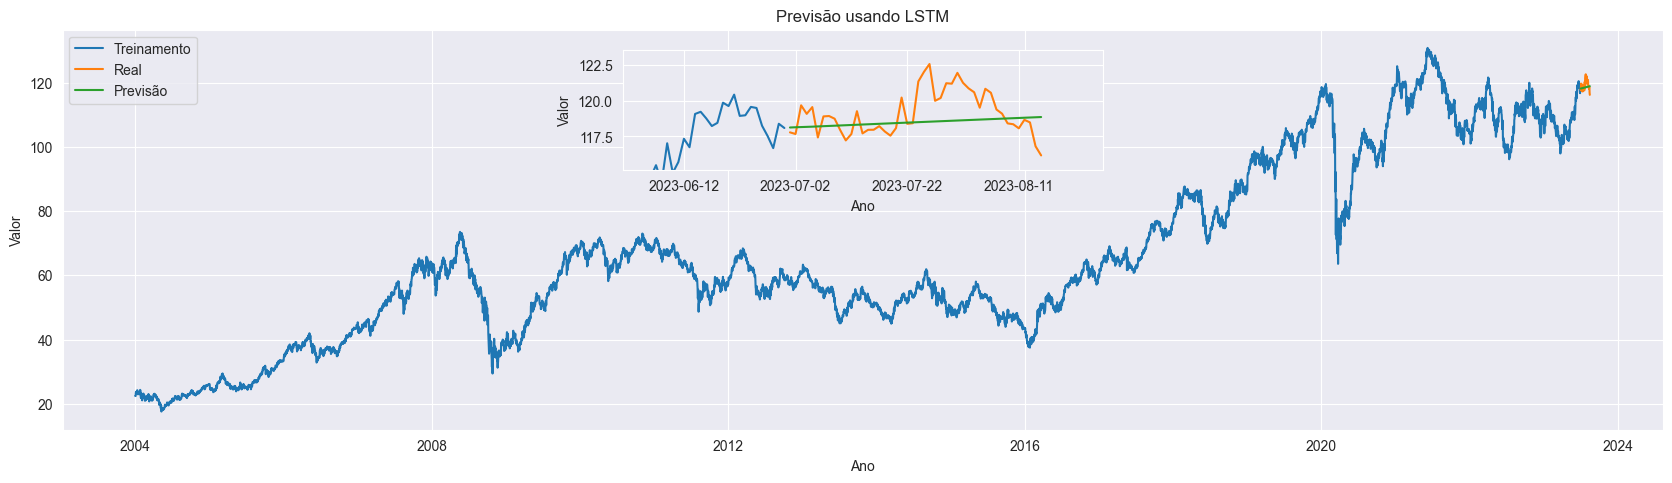

In [59]:
fig = plt.figure(figsize=(16, 4))
eixo = fig.add_axes([0, 0, 1, 1])
eixo.plot(train.index, train_data, label='Treinamento')
eixo.plot(test.index, test_data, label='Real')
eixo.plot(test.index, forecast_lstm, label='Previsão')
eixo.legend()
eixo.set_title('Previsão usando LSTM')
eixo.set_xlabel('Ano')
eixo.set_ylabel('Valor')
eixo2 = fig.add_axes([0.35, 0.65, 0.3, 0.3])
eixo2.plot(train.index, train_data)
eixo2.plot(test.index, test_data, label='Real') 
eixo2.plot(test.index, forecast_lstm, label='Previsão')
eixo2.set_xlim(pd.Timestamp('2023-06-01'), pd.Timestamp('2023-08-26')) # type: ignore
eixo2.set_ylim(min(min(test_data), min(forecast_lstm)) - 1, max(max(test_data), max(forecast_lstm)) + 1) # type: ignore
eixo2.set_xlabel('Ano')
eixo2.set_ylabel('Valor')
eixo2.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
plt.show()

- Avaliação dos modelos

In [60]:
model_names = [
    'Naive',
    'SeasonalNaive',
    'SeasWA',
    'WindowAverage',
    'RWD',
    'HistoricAverage',
    'SES',
    'SESOpt',
    'SeasonalES',
    'SeasESOpt',
    'Holt',
    'HoltWinters',
    'ADIDA',
    'CrostonClassic',
    'CrostonOptimized',
    'CrostonSBA',
    'IMAPA',
    'TSB',
    'MSTL',
    'DynamicOptimizedTheta',
    'GARCH',
    'ARCH',
    'AutoARIMA',
    'AutoETS',
    'CES',
    'AutoTheta',
    'SarimaX',
    'LSTM'
]

mape_errors = [
    mape_error(forecast['y'].values, forecast['Naive'].values),
    mape_error(forecast['y'].values, forecast['SeasonalNaive'].values),
    mape_error(forecast['y'].values, forecast['SeasWA'].values),
    mape_error(forecast['y'].values, forecast['WindowAverage'].values),
    mape_error(forecast['y'].values, forecast['RWD'].values),
    mape_error(forecast['y'].values, forecast['HistoricAverage'].values),
    mape_error(forecast['y'].values, forecast['SES'].values),
    mape_error(forecast['y'].values, forecast['SESOpt'].values),
    mape_error(forecast['y'].values, forecast['SeasonalES'].values),
    mape_error(forecast['y'].values, forecast['SeasESOpt'].values),
    mape_error(forecast['y'].values, forecast['Holt'].values),
    mape_error(forecast['y'].values, forecast['HoltWinters'].values),
    mape_error(forecast['y'].values, forecast['ADIDA'].values),
    mape_error(forecast['y'].values, forecast['CrostonClassic'].values),
    mape_error(forecast['y'].values, forecast['CrostonOptimized'].values),
    mape_error(forecast['y'].values, forecast['CrostonSBA'].values),
    mape_error(forecast['y'].values, forecast['IMAPA'].values),
    mape_error(forecast['y'].values, forecast['TSB'].values),
    mape_error(forecast['y'].values, forecast['MSTL'].values),
    mape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values),
    mape_error(forecast['y'].values, forecast['GARCH(10,1)'].values),
    mape_error(forecast['y'].values, forecast['ARCH(10)'].values),
    mape_error(forecast['y'].values, forecast['AutoARIMA'].values),
    mape_error(forecast['y'].values, forecast['AutoETS'].values),
    mape_error(forecast['y'].values, forecast['CES'].values),
    mape_error(forecast['y'].values, forecast['AutoTheta'].values),
    mape_error(test['y'].values, sarima_forecast_result.values),
    mape_error(test['y'].values, forecast_lstm_values)
]
wmape_errors = [
    wmape_error(forecast['y'].values, forecast['Naive'].values),
    wmape_error(forecast['y'].values, forecast['SeasonalNaive'].values),
    wmape_error(forecast['y'].values, forecast['SeasWA'].values),
    wmape_error(forecast['y'].values, forecast['WindowAverage'].values),
    wmape_error(forecast['y'].values, forecast['RWD'].values),
    wmape_error(forecast['y'].values, forecast['HistoricAverage'].values),
    wmape_error(forecast['y'].values, forecast['SES'].values),
    wmape_error(forecast['y'].values, forecast['SESOpt'].values),
    wmape_error(forecast['y'].values, forecast['SeasonalES'].values),
    wmape_error(forecast['y'].values, forecast['SeasESOpt'].values),
    wmape_error(forecast['y'].values, forecast['Holt'].values),
    wmape_error(forecast['y'].values, forecast['HoltWinters'].values),
    wmape_error(forecast['y'].values, forecast['ADIDA'].values),
    wmape_error(forecast['y'].values, forecast['CrostonClassic'].values),
    wmape_error(forecast['y'].values, forecast['CrostonOptimized'].values),
    wmape_error(forecast['y'].values, forecast['CrostonSBA'].values),
    wmape_error(forecast['y'].values, forecast['IMAPA'].values),
    wmape_error(forecast['y'].values, forecast['TSB'].values),
    wmape_error(forecast['y'].values, forecast['MSTL'].values),
    wmape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values),
    wmape_error(forecast['y'].values, forecast['GARCH(10,1)'].values),
    wmape_error(forecast['y'].values, forecast['ARCH(10)'].values),
    wmape_error(forecast['y'].values, forecast['AutoARIMA'].values),
    wmape_error(forecast['y'].values, forecast['AutoETS'].values),
    wmape_error(forecast['y'].values, forecast['CES'].values),
    wmape_error(forecast['y'].values, forecast['AutoTheta'].values),
    wmape_error(test['y'].values, sarima_forecast_result.values),
    wmape_error(test['y'].values, forecast_lstm_values)
]

smape_errors = [
    smape_error(forecast['y'].values, forecast['Naive'].values),
    smape_error(forecast['y'].values, forecast['SeasonalNaive'].values),
    smape_error(forecast['y'].values, forecast['SeasWA'].values),
    smape_error(forecast['y'].values, forecast['WindowAverage'].values),
    smape_error(forecast['y'].values, forecast['RWD'].values),
    smape_error(forecast['y'].values, forecast['HistoricAverage'].values),
    smape_error(forecast['y'].values, forecast['SES'].values),
    smape_error(forecast['y'].values, forecast['SESOpt'].values),
    smape_error(forecast['y'].values, forecast['SeasonalES'].values),
    smape_error(forecast['y'].values, forecast['SeasESOpt'].values),
    smape_error(forecast['y'].values, forecast['Holt'].values),
    smape_error(forecast['y'].values, forecast['HoltWinters'].values),
    smape_error(forecast['y'].values, forecast['ADIDA'].values),
    smape_error(forecast['y'].values, forecast['CrostonClassic'].values),
    smape_error(forecast['y'].values, forecast['CrostonOptimized'].values),
    smape_error(forecast['y'].values, forecast['CrostonSBA'].values),
    smape_error(forecast['y'].values, forecast['IMAPA'].values),
    smape_error(forecast['y'].values, forecast['TSB'].values),
    smape_error(forecast['y'].values, forecast['MSTL'].values),
    smape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values),
    smape_error(forecast['y'].values, forecast['GARCH(10,1)'].values),
    smape_error(forecast['y'].values, forecast['ARCH(10)'].values),
    smape_error(forecast['y'].values, forecast['AutoARIMA'].values),
    smape_error(forecast['y'].values, forecast['AutoETS'].values),
    smape_error(forecast['y'].values, forecast['CES'].values),
    smape_error(forecast['y'].values, forecast['AutoTheta'].values),
    smape_error(test['y'].values, sarima_forecast_result.values),
    smape_error(test['y'].values, forecast_lstm_values) 
]

df_error = pd.DataFrame({'model': model_names, 'mape': mape_errors, 'wmape': wmape_errors, 'smape': smape_errors})
df_error.to_csv('Data/Errors.csv', index=False)

MAPE (Mean Absolute Percentage Error): 1.13%
MAPE (Mean Absolute Percentage Error): 1.30%
MAPE (Mean Absolute Percentage Error): 1.05%
MAPE (Mean Absolute Percentage Error): 1.09%
MAPE (Mean Absolute Percentage Error): 1.03%
MAPE (Mean Absolute Percentage Error): 45.04%
MAPE (Mean Absolute Percentage Error): 16.00%
MAPE (Mean Absolute Percentage Error): 1.14%
MAPE (Mean Absolute Percentage Error): 54.22%
MAPE (Mean Absolute Percentage Error): 1.27%
MAPE (Mean Absolute Percentage Error): 1.03%
MAPE (Mean Absolute Percentage Error): 1.19%
MAPE (Mean Absolute Percentage Error): 1.12%
MAPE (Mean Absolute Percentage Error): 1.31%
MAPE (Mean Absolute Percentage Error): 1.12%
MAPE (Mean Absolute Percentage Error): 6.13%
MAPE (Mean Absolute Percentage Error): 1.12%
MAPE (Mean Absolute Percentage Error): 8.19%
MAPE (Mean Absolute Percentage Error): 1.82%
MAPE (Mean Absolute Percentage Error): 1.12%
MAPE (Mean Absolute Percentage Error): 101.38%
MAPE (Mean Absolute Percentage Error): 101.36%
MAP

In [61]:
df_erros = pd.read_csv('Data/Errors.csv')
df_erros_prophet = pd.read_csv('Data/ErrorsProphet.csv')
df_mesclado = pd.concat([df_erros_prophet, df_erros], ignore_index=True)
df_mesclado.to_csv('erros.csv', index=False)

In [62]:
fig = plot_error(df_mesclado, 'mape', 'MAPE', 'MAPE (Mean Absolute Percentage Error)')
fig.show()

In [63]:
fig = plot_error(df_mesclado, 'wmape', 'wMAPE', 'wMAPE (Weighted Mean Absolute Percentage Error)')
fig.show()

In [64]:
fig = plot_error(df_mesclado, 'smape', 'sMAPE', 'sMAPE (Weighted Mean Absolute Percentage Error)')
fig.show()